https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/
https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/
https://www.kaggle.com/datasets/shubhamgoel27/dermnet

In [25]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
train_dir =  Path('Skin_dataset_trg')
val_dir = Path('Skin_dataset_val')
test_dir = Path('Skin_dataset_tesr')

In [27]:
os.listdir(train_dir)

['resized_data_class_1_Melanoma',
 'resized_data_class_2_Nail_Fungus',
 'resized_data_class_4_Viral Infections']

In [28]:
def load_train():
    Melanoma_dir=train_dir/'resized_data_class_1_Melanoma'
    Nail_Fungus_dir = train_dir/'resized_data_class_2_Nail_Fungus'
    Viral_Infections_dir = train_dir/'resized_data_class_4_Viral Infections'
    Melanoma = Melanoma_dir.glob('*.jpg')
    Nail_Fungus = Nail_Fungus_dir.glob('*.jpg')
    Viral_Infection = Viral_Infections_dir.glob('*.jpg')
    train_data = []
    train_label = []
    
    for img in Melanoma:
        train_data.append(img)
        train_label.append('Melanoma')
    
    for img in Nail_Fungus:
        train_data.append(img)
        train_label.append('Nail_Fungus')
        
    for img in Viral_Infection:
        train_data.append(img)
        train_label.append('Viral_Infection')
        
    df = pd.DataFrame(train_data)
    df.columns = ['images']
    df['labels']= train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [29]:
train_data = load_train()
train_data.shape

(1700, 2)

In [30]:
train_data.head()

,images,labels
0,Skin_dataset_trg\resized_data_class_1_Melanoma...,Melanoma
1,Skin_dataset_trg\resized_data_class_4_Viral In...,Viral_Infection
2,Skin_dataset_trg\resized_data_class_4_Viral In...,Viral_Infection
3,Skin_dataset_trg\resized_data_class_2_Nail_Fun...,Nail_Fungus
4,Skin_dataset_trg\resized_data_class_2_Nail_Fun...,Nail_Fungus


In [56]:
def prepare_and_load(isval=True):
    if isval==True:
        Melanoma_dir=val_dir/'resized_data_class_1_Melanoma'
        Nail_Fungus_dir = val_dir/'resized_data_class_2_Nail_Fungus'
        Viral_Infections_dir = val_dir/'resized_data_class_4_Viral Infections'
        
    else:
        Melanoma_dir=test_dir/'resized_data_class_1_Melanoma'
        Nail_Fungus_dir = test_dir/'resized_data_class_2_Nail_Fungus'
        Viral_Infections_dir = test_dir/'resized_data_class_4_Viral Infections'
        
    Melanoma = Melanoma_dir.glob('*.jpg')
    Nail_Fungus = Nail_Fungus_dir.glob('*.jpg')
    Viral_Infection = Viral_Infections_dir.glob('*.jpg')
    data, labels = ([] for x in range(3))
    def prepare(decease):
        for img in decease:
            img = cv2.imread(str(img))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255
            if decease == Melanoma:
                label = to_categorical(0, num_classes=3)
            elif decease == Nail_Fungus:
                label = to_categorical(1, num_classes=3)
            else:
                label = to_categorical(2, num_classes=3)
            
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(Melanoma)
    prepare(Viral_Infection)
    d, l = prepare(Nail_Fungus)
    d = np.array(d)
    l = np.array(l)
    return d, l

In [32]:
val_data, val_label = prepare_and_load(isval=True)
len(val_data)

684

In [53]:
def data_gen(data, batch_size):
    n = len(data)
    steps = n//batch_size
    
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 3), dtype=np.float32)
    
    indices = np.arange(n)
    
    i=0
    while True:
        np.random.shuffle(indices)
        
        count =0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label== 'Melanoma':
                label=0
            elif label== 'Nail_Fungus':
                label=1
            else:
                label=2
            encoded_label = to_categorical(label, num_classes=3)
            img = cv2.imread(str(img_name))
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255
            
            batch_data[caount] = orig_img
            batch_labels[count] = encoded_label
            
            count+=1
            
            if count==batch_size-1:
                break
        
        i+=1
        yield batch_data, batch_labels
        
        if i>=steps:
            i=0

In [34]:
def plot(image_batch, label_batch):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        img = cv2.imread(str(image_batch[i]))
        plt.imshow()
        plt.title(label_batch[i])
        plt.axis('off')

In [37]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_2 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

In [50]:
batch_size = 16
nb_epochs = 3

In [39]:
train_data_gen = data_gen(data=train_data, batch_size=batch_size)
nb_train_steps = train_data.shape[0]//batch_size

In [43]:
def vgg16_model(num_classes=None):
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    
    x = Dense(1024, activation='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(model.input, x)
    
    return model

In [45]:
vgg_conv = vgg16_model(3)
for layer in vgg_conv.layers[: 10]:
    layer.trainable = False

553467096/553467096 [==============================] - 254s 0us/step


In [48]:
opt = Adam(lr=0.0001, decay = 1e-5)
vgg_conv.compile(loss= 'binary_crossentropy', metrics= ['accuracy'], optimizer = opt)

C:\Users\laptophut\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [57]:
histrory = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data = (val_data, val_label), class_weight = {0:1.0, 1:0.4})

StopIteration: 

=========================================================================================================================

LOding to the data pipeline

Trg data

In [2]:
data_trg = tf.keras.utils.image_dataset_from_directory('Skin_dataset_trg', image_size=(224, 224))

Found 1700 files belonging to 3 classes.


In [3]:
data_trg_iterator = data_trg.as_numpy_iterator()
data_trg_iterator

In [4]:
batch = data_trg_iterator.next()
batch
batch[0].shape

(32, 224, 224, 3)

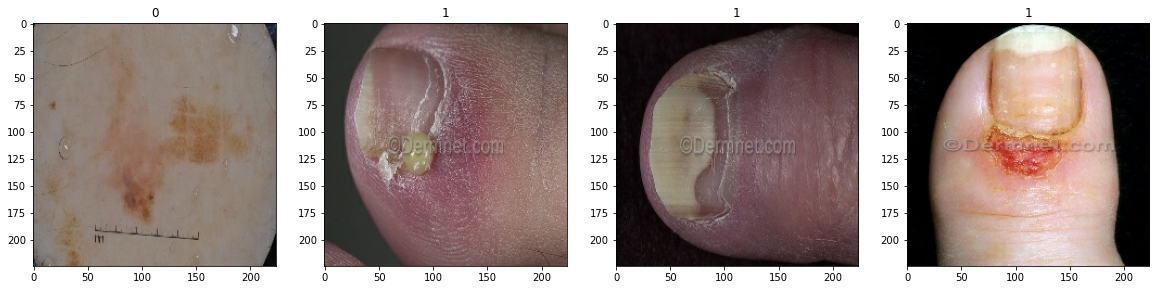

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,15))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
data_trg = data_trg.map(lambda x,y: (x/255, y))
data_trg

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
data_trg.as_numpy_iterator().next()

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.83137256, 0.65882355, 0.48235294],
          [0.81176

Val data

In [8]:
data_val = tf.keras.utils.image_dataset_from_directory('Skin_dataset_val', image_size=(224, 224))

Found 731 files belonging to 3 classes.


In [9]:
data_val_iterator = data_trg.as_numpy_iterator()
data_val_iterator

In [10]:
data_val = data_val.map(lambda x,y: (x/255, y))
data_val

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation 
from keras.regularizers import l2

# Image augmantation

In [12]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [13]:
# image = tf.cast(tf.expand_dims(img, 0), tf.float32)
# image

In [14]:
# model = Sequential(data_augmentation(image))

In [15]:
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(64, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.6))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(4, activation='softmax'))

# =======================================================================
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(474, 720, 3)))
# model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Conv2D(64, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())


# model.add(Flatten())

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# # model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.5)))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))
# model.summary()


# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(254, activation='relu'))
# model.add(Dense(4, activation='softmax'))



##=====================================================================================####
model = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(224,224,3)),
                             tf.keras.layers.RandomRotation(0.2),
                             tf.keras.layers.RandomZoom(.5, .2),
                             tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu', input_shape=(224,224,3)),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(64, 3, activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(128, 3, activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(64, 3, activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(4, activation='softmax'),
                            ])


In [16]:
# Y_pred

In [17]:
# y_pred = np.argmax(Y_pred, axis=1)
# y_pred

In [18]:
# optimizer = keras.optimizers.Adam(lr=0.007)

In [19]:
# model.compile("Adam", loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', 'sparse_categorical_accuracy'])

In [20]:
model.compile("Adam", loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [21]:
# logdir='logs'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
hist = model.fit(data_trg, epochs=5, validation_data=data_val)

Epoch 1/5
54/54 [==============================] - 378s 6s/step - loss: 1.1855 - Accuracy: 0.3788 - val_loss: 0.8787 - val_Accuracy: 0.6731
Epoch 2/5
54/54 [==============================] - 350s 6s/step - loss: 0.9878 - Accuracy: 0.5424 - val_loss: 0.8357 - val_Accuracy: 0.6402
Epoch 3/5
54/54 [==============================] - 353s 7s/step - loss: 0.8753 - Accuracy: 0.6035 - val_loss: 0.7287 - val_Accuracy: 0.6662
Epoch 4/5
54/54 [==============================] - 350s 6s/step - loss: 0.8751 - Accuracy: 0.6041 - val_loss: 0.7209 - val_Accuracy: 0.6731
Epoch 5/5
54/54 [==============================] - 328s 6s/step - loss: 0.8347 - Accuracy: 0.6147 - val_loss: 0.8063 - val_Accuracy: 0.6908


In [23]:
Y_pred = model.predict_generator(data_val)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

C:\Users\laptophut\AppData\Local\Temp\ipykernel_13260\886211792.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(data_val)


array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [24]:
y_val = np.concatenate([y_val for x, y_val in data_val], axis=0)
y_val

array([1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2,
       1, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2,
       0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 0,
       1, 1, 2, 1, 0, 0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 0, 0, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 0, 2, 0, 0, 1, 2,
       2, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2,
       0, 2, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       0, 0, 1, 0, 2, 0, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 1, 2,
       0, 2, 0, 0, 2, 0, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 2, 0, 1, 0, 2, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 0, 0, 0,
       1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 1, 1,
       1, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0,

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_val, y_pred)

array([[ 72, 149,   0],
       [123, 198,   0],
       [ 68, 121,   0]], dtype=int64)

In [26]:
target_names = ['Melanoma', 'Nail_Fungers', 'Viral_Infections']

In [27]:
print(classification_report(y_val, y_pred, target_names= target_names))

                  precision    recall  f1-score   support

        Melanoma       0.27      0.33      0.30       221
    Nail_Fungers       0.42      0.62      0.50       321
Viral_Infections       0.00      0.00      0.00       189

        accuracy                           0.37       731
       macro avg       0.23      0.31      0.27       731
    weighted avg       0.27      0.37      0.31       731



C:\Users\laptophut\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\laptophut\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\laptophut\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of the test set

In [65]:
test_nw = tf.keras.utils.image_dataset_from_directory('Skin_dataset_test_nw', image_size=(224, 224))

Found 30 files belonging to 1 classes.


In [69]:
y_pred_test=model.predict_generator(test_nw, 30)
y_pred_test

C:\Users\laptophut\AppData\Local\Temp\ipykernel_4928\2856781194.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_test=model.predict_generator(test_nw, 30)


array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 8.6178559e-01, 1.3821442e-01, 0.0000000e+00],
       [0.0000000e+00, 9.9617296e-01, 3.8270424e-03, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+

Plot Performance

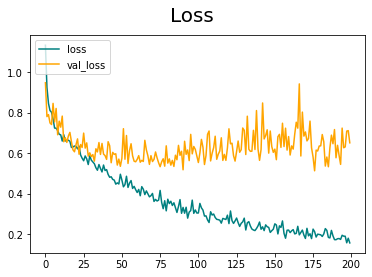

In [70]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

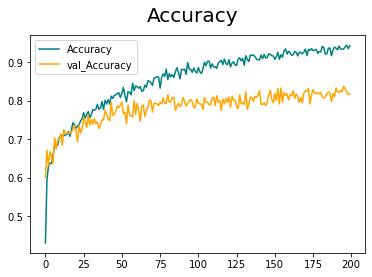

In [71]:
fig = plt.figure()
plt.plot(hist.history['Accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_Accuracy'], color='orange', label='val_Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [141]:
test_nw = tf.keras.utils.image_dataset_from_directory('test_nw', image_size=(224, 224))

Found 1 files belonging to 1 classes.


In [142]:
pred=model.predict(test_nw)

1/1 [==============================] - 0s 64ms/step


In [143]:
import numpy as np

In [144]:
print(pred[0])
print(np.argmax(pred[0]))

[0. 0. 1. 0.]
2


In [105]:
model.save("model.h5")

https://www.projectpro.io/article/deep-learning-for-image-classification-in-python-with-cnn/418